<a href="https://colab.research.google.com/github/ras1364/DetectFakeReviewsUsing-Sentence_BERT/blob/main/FakeReviewDetectionUsingSentenceBertVer3_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this code, the sentences that make up a comment are sent individually to a Sentence-BERT encoder and form a three-dimensional vector, and then the sentences are added together by AveragePooling and entered into the NLP network as a comment.**

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv


In [3]:
X_test = pd.read_csv("/content/X_test.csv")
X_train = pd.read_csv("/content/X_train.csv")
y_test = pd.read_csv("/content/y_test.csv")
y_train = pd.read_csv("/content/y_train.csv")

In [4]:
max_length = 100
# for x in range(0,len(X_train)):
#   line = X_train.loc[x].at["text"]
#   if max_length < len(line.split()) :
#     max_length = len(line.split())

print(max_length)


100


In [5]:
from gensim.parsing.preprocessing import remove_stopwords

def preprocess(text):
  return remove_stopwords(text)

X_train["stemmed_text_data"] = X_train["text"].map(preprocess)
X_test["stemmed_text_data"] = X_test["text"].map(preprocess)

In [6]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=947f856f5136a65791d841d7e1bd7535135c7ca8535e798eae196403acefaa0d
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [7]:
def percent_complete(step, total_steps, bar_width=60, title="", print_perc=True):
    import sys

    # UTF-8 left blocks: 1, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8
    utf_8s = ["█", "▏", "▎", "▍", "▌", "▋", "▊", "█"]
    perc = 100 * float(step) / float(total_steps)
    max_ticks = bar_width * 8
    num_ticks = int(round(perc / 100 * max_ticks))
    full_ticks = num_ticks / 8      # Number of full blocks
    part_ticks = num_ticks % 8      # Size of partial block (array index)
    
    disp = bar = ""                 # Blank out variables
    bar += utf_8s[0] * int(full_ticks)  # Add full blocks into Progress Bar
    
    # If part_ticks is zero, then no partial block, else append part char
    if part_ticks > 0:
        bar += utf_8s[part_ticks]
    
    # Pad Progress Bar with fill character
    bar += "▒" * int((max_ticks/8 - float(num_ticks)/8.0))
    
    if len(title) > 0:
        disp = title + ": "         # Optional title to progress display
    
    # Print progress bar in green: https://stackoverflow.com/a/21786287/6929343
    disp += "\x1b[0;32m"            # Color Green
    disp += bar                     # Progress bar to progress display
    disp += "\x1b[0m"               # Color Reset
    if print_perc:
        # If requested, append percentage complete to progress display
        if perc > 100.0:
            perc = 100.0            # Fix "100.04 %" rounding error
        disp += " {:6.2f}".format(perc) + " %"
    
    # Output to terminal repetitively over the same line using '\r'.
    sys.stdout.write("\r" + disp)
    sys.stdout.flush()

In [45]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import tensorflow as tf

def encode(text, maxlen,mtitle):
  embeddings=[]
  counter = 1
  for row in text:
    embedding =[]
    counter+=1
    percent_complete(counter, len(text), title=mtitle)
    for sent in sent_tokenize(row):
      embedding.append(sbert_model.encode(sentences=sent ,convert_to_numpy=True ))
    
    loop = 50 - len(embedding)
    for x in range(loop):
      embedding.append(np.zeros([384],dtype=float))
    embeddings.append(embedding)

  return embeddings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
X_train_encoded = encode(X_train.stemmed_text_data,max_length,"X_train_embedding")

X_train_embedding: ████████████████████████████████████████████████████████████ 100.00 %

In [47]:
X_test_encoded = encode(X_test.stemmed_text_data,max_length,"X_test_embedding")

X_test_embedding: ████████████████████████████████████████████████████████████▏ 100.00 %

In [62]:
X_train_embedding_squeezed = np.squeeze(X_train_encoded)
X_test_embedding_squeezed = np.squeeze(X_test_encoded)

In [63]:
print("X_train.shape = " , np.shape(X_train_embedding_squeezed), " y_train.shape = ", y_train["deceptive"].shape)
print("X_test.shape = " , np.shape(X_test_embedding_squeezed), " y_test.shape = ", y_test["deceptive"].shape)

X_train.shape =  (1200, 50, 384)  y_train.shape =  (1200,)
X_test.shape =  (400, 50, 384)  y_test.shape =  (400,)


In [112]:
from keras.models import Sequential
from keras.layers import Dense,AveragePooling1D
import keras

# define and fit the final model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
   ] 
model = Sequential()
model.add(keras.Input(shape=(50,384,)))
model.add(AveragePooling1D(pool_size=(50)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)


In [113]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling1d (AverageP  (None, 1, 384)           0         
 ooling1D)                                                       
                                                                 
 dense_26 (Dense)            (None, 1, 64)             24640     
                                                                 
 dense_27 (Dense)            (None, 1, 32)             2080      
                                                                 
 dense_28 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 26,753
Trainable params: 26,753
Non-trainable params: 0
_________________________________________________________________


In [114]:
model.fit(X_train_embedding_squeezed,y_train.deceptive, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
19/19 [==============================] - 2s 7ms/step - loss: 0.6922 - accuracy: 0.5808 - precision: 0.5708 - recall: 0.6517
Epoch 2/50
19/19 [==============================] - 0s 6ms/step - loss: 0.6884 - accuracy: 0.6908 - precision: 0.6638 - recall: 0.7733
Epoch 3/50
19/19 [==============================] - 0s 7ms/step - loss: 0.6803 - accuracy: 0.7150 - precision: 0.7304 - recall: 0.6817
Epoch 4/50
19/19 [==============================] - 0s 6ms/step - loss: 0.6652 - accuracy: 0.6425 - precision: 0.5968 - recall: 0.8783
Epoch 5/50
19/19 [==============================] - 0s 7ms/step - loss: 0.6420 - accuracy: 0.7075 - precision: 0.7180 - recall: 0.6833
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 0.6111 - accuracy: 0.7567 - precision: 0.7601 - recall: 0.7500
Epoch 7/50
19/19 [==============================] - 0s 6ms/step - loss: 0.5741 - accuracy: 0.7775 - precision: 0.7876 - recall: 0.7600
Epoch 8/50
19/19 [==============================] - 0s 

In [115]:
model.evaluate(X_test_embedding_squeezed, y_test.deceptive)

13/13 [==============================] - 1s 6ms/step - loss: 0.4211 - accuracy: 0.8075 - precision: 0.8254 - recall: 0.7800


[0.4211236834526062,
 0.8075000047683716,
 0.8253968358039856,
 0.7799999713897705]

In [116]:
y_predicted = model.predict(X_test_embedding_squeezed)
y_predicted = y_predicted.flatten()

13/13 [==============================] - 0s 5ms/step


In [117]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,

In [118]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test.deceptive, y_predicted)
cm 

array([[167,  33],
       [ 44, 156]])

Text(33.0, 0.5, 'Truth')

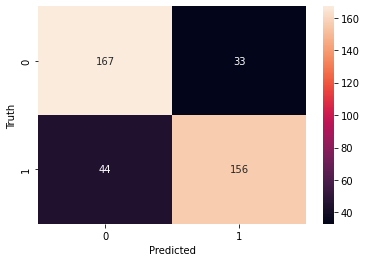

In [119]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [120]:
print(classification_report(y_test.deceptive, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       200
           1       0.83      0.78      0.80       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400

